Library Imports

In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


In [59]:
# Define path to the data directory
data_dir = Path('data/binary_split')

data_dir

WindowsPath('data/binary_split')

In [60]:
train_dir = data_dir / 'train'
print(train_dir)
test_dir = data_dir / 'test'

tumor_dir = train_dir / 'tumor'
no_tumor_dir = train_dir / 'no_tumor'
print(tumor_dir)

data\binary_split\train
data\binary_split\train\tumor


In [147]:

data_dir = Path("../data/binary_split")
train_dir = data_dir / "train"
tumor_dir = train_dir / "tumor"
no_tumor_dir = train_dir / "no_tumor"


# print("CWD:", os.getcwd())
# print("Path:", tumor_dir.resolve())
# print("Dir exists:", tumor_dir.exists())
# print("Contents:", list(tumor_dir.iterdir())[:5])

tumor_cases = list(tumor_dir.glob("*.jpg"))
no_tumor_cases = list(no_tumor_dir.glob("*.jpg"))

print(f"Tumor Cases: {len(tumor_cases)}")
print(f"No Tumor Cases: {len(no_tumor_cases)}")

# See some file names
for case in tumor_cases[:5]:
    print(case.name)


Tumor Cases: 4117
No Tumor Cases: 1595
Tr-glTr_0000.jpg
Tr-glTr_0001.jpg
Tr-glTr_0002.jpg
Tr-glTr_0003.jpg
Tr-glTr_0004.jpg


Prepping the Data

In [148]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

for img in no_tumor_cases:
    train_data.append((img, 0))  # 0 for no tumor

for img in tumor_cases:
    train_data.append((img, 1))  # 1 for tumor

print(f"Total training data: {len(train_data)}")
print("First 5 entries in train_data:" + str(train_data[:5]))
print(train_data[5][1])

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Display the first few rows of the dataframe
train_data.head()

Total training data: 5712
First 5 entries in train_data:[(WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0000.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0001.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0002.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0003.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0004.jpg'), 0)]
0


,image,label
0,..\data\binary_split\train\tumor\Tr-pi_0911.jpg,1
1,..\data\binary_split\train\tumor\Tr-me_0501.jpg,1
2,..\data\binary_split\train\tumor\Tr-gl_1174.jpg,1
3,..\data\binary_split\train\no_tumor\Tr-no_0879...,0
4,..\data\binary_split\train\tumor\Tr-pi_0617.jpg,1


In [149]:
train_data.shape

(5712, 2)

In [150]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

label
1    4117
0    1595
Name: count, dtype: int64


Plotting the values

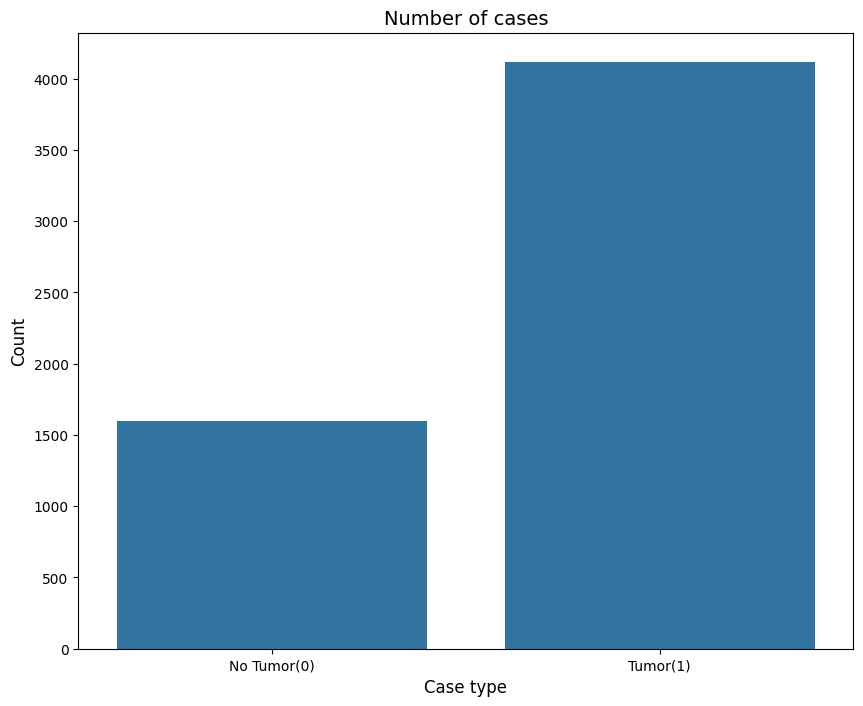

In [151]:
# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['No Tumor(0)', 'Tumor(1)'])
plt.show()

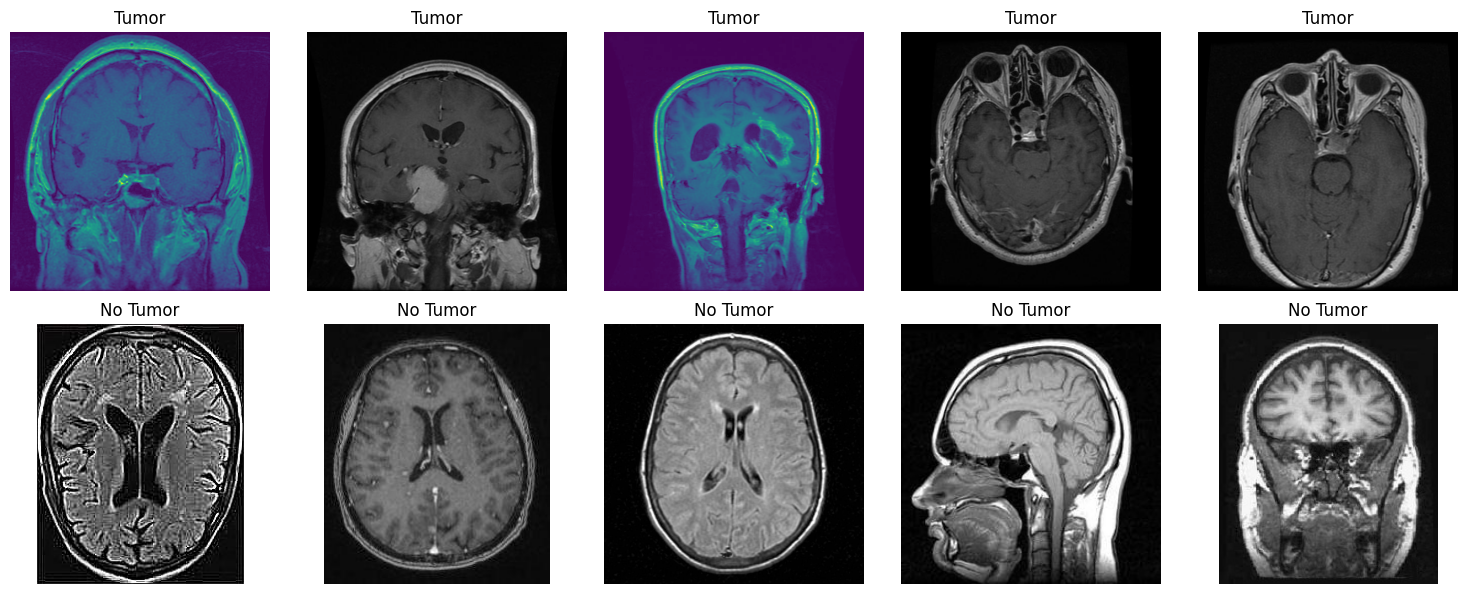

In [152]:
import matplotlib.pyplot as plt
from PIL import Image

# Separate tumor and no_tumor images
tumor_images = train_data[train_data['label'] == 1]['image'].values[:5]
no_tumor_images = train_data[train_data['label'] == 0]['image'].values[:5]

plt.figure(figsize=(15, 6))

# Plot tumor images (top row)
for i, img_path in enumerate(tumor_images):
    plt.subplot(2, 5, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title("Tumor")
    plt.axis('off')

# Plot no_tumor images (bottom row)
for i, img_path in enumerate(no_tumor_images):
    plt.subplot(2, 5, i + 6)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title("No Tumor")
    plt.axis('off')

plt.tight_layout()
plt.show()


Preprocessing All Images

In [153]:
from PIL import Image

def preprocess_image(path, target_size=(28, 28)):
    img = Image.open(path).convert('L')  # Convert to grayscale
    img = img.resize(target_size)
    img = np.array(img) / 255.0          # Normalize to [0, 1]
    img = img.reshape(target_size[0], target_size[1], 1)  # Add channel dim
    return img

# # Load image data
# X = np.array([preprocess_image(p) for p in train_data['image']])
# y = train_data['label'].values

# print("✅ Loaded image data:")
# print("X shape:", X.shape)
# print("y shape:", y.shape)


In [154]:
print(type(train_data))
print(train_data[:3])

train_data = list(zip(train_data['image'].map(Path), train_data['label']))

<class 'pandas.core.frame.DataFrame'>
                                             image  label
0  ..\data\binary_split\train\tumor\Tr-pi_0911.jpg      1
1  ..\data\binary_split\train\tumor\Tr-me_0501.jpg      1
2  ..\data\binary_split\train\tumor\Tr-gl_1174.jpg      1


In [155]:
from tqdm import tqdm  # for progress bar

X = []
y = []

for path, label in tqdm(list(train_data), desc="Loading Images"):
    img = preprocess_image(path)  # new grayscale version
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(f"X shape: {X.shape} | y shape: {y.shape}")

Loading Images: 100%|██████████| 5712/5712 [01:02<00:00, 91.87it/s] 

X shape: (5712, 28, 28, 1) | y shape: (5712,)
